In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import get_file

In [4]:
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text_ = open(path_to_file, 'rb').read().decode()

print(text_[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [8]:
vocab_size_ = 10_000
seq_length_ = 100

# Adapt TextVectorization to full text
vectorizer = TextVectorization(max_tokens=vocab_size_, output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices([text_]).batch(1)
vectorizer.adapt(text_ds)

# Vectorize the text
vectorized_text = vectorizer([text_])[0]
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


In [83]:
def create_sequences(tokens, seq_length):
    input_seqs = []
    target_seqs = []
    for i in range(len(tokens) - seq_length):
        input_seqs.append(tokens[i:i + seq_length])
        target_seqs.append(tokens[i + 1:i + seq_length + 1])
    return np.array(input_seqs), np.array(target_seqs)

X, y = create_sequences(vectorized_text.numpy(), seq_length_)

print("Number of sequences generated:", len(X))
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated")

assert X.size > 0, "Input data X is empty"
assert y.size > 0, "Input data y is empty"
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Number of sequences generated: 202546
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X: (202546, 100)
Shape of y: (202546, 100)


### Implement Transformer Block

In [85]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

### Implement Transformer Model

In [86]:
class TransformerModel(Model):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length, rate=0.1):
        super(TransformerModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim, rate=rate)
            for _ in range(num_layers)
        ]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(self.vocab_size, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        if len(inputs.shape) < 2:
            raise ValueError("inputs must be a vectorized tensor")
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        return self.dense(x)

In [87]:
embed_dim_ = 256
num_heads_ = 8
ff_dim_ = 512
num_layers_ = 4

# Build the Transformer model
model = TransformerModel(vocab_size_, embed_dim_, num_heads_, ff_dim_, num_layers_, seq_length_)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length_), maxval=vocab_size_, dtype=tf.int32))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "transformer_model_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (1, 100, 256)          │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_68            │ ?                      │     2,367,488 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_69            │ ?                      │     2,367,488 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_70            │ ?                      │     2,367,488 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_71            │ ?                      │     2,367,488 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (1, 100, 10000)        │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,599,952 (55.69 MB)

 Trainable params: 14,599,952 (55.69 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
X_train = X[:10000]
y_train = y[:10000]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (10000, 100)
Shape of y_train: (10000, 100)


In [89]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on th e full input and targets sequences
hist = model.fit(X_train, y_train, epochs=2, batch_size=32, callbacks=[early_stopping])

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - loss: 10.7454
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 609s 2s/step - loss: 10.8635


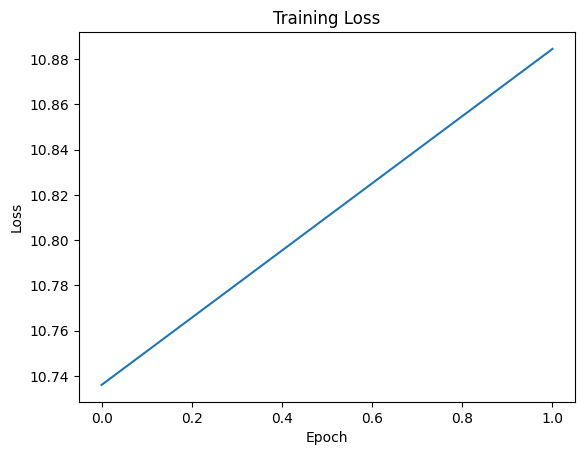

In [90]:
plt.plot(hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()